# Предсказание социально-демографических характеристик пользователей Rutube

Пользователи RUTUBE не всегда указывают свои данные, такие как возраст и пол, что затрудняет формирование портрета пользователя и создание персонализированных рекомендаций. Это ограничивает возможности платформы в предоставлении контента, который наиболее подходит интересам и потребностям пользователей, тем самым ухудшая пользовательский опыт.

Необходимо разработать модель, которая на основе истории просмотров сможет предсказывать пол и возраст пользователя. В качестве baseline решения мы предоставляем этот ноутбук.


## Загрузка данных

    В таблице train_events указаны события пользователей Rutube 
    - event_date : Дата события
    - viewer_uid : Идентификатор пользователя
    - region : Регион пользователя
    - rutube_video_id : Идентификатор видео
    - ua_device_type : Устройство пользователя
    - ua_client_type : Приложение/браузер 
    - ua_os : Операционная система устройства пользователя
    - ua_client_name : Веб-браузер/приложение, с которого пользователь просматривал видео
    - total_watchtime : Время просмотра в секундах

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

In [186]:
from datetime import datetime
import pytz


# Функция для перевода времени
def convert_to_local_time(row):
    # Парсим timestamp
    event_time = pd.to_datetime(row['event_timestamp'])
    
    # Получаем часовой пояс региона
    region_name = row['region']
    if region_name in region_timezones:
        timezone = pytz.timezone(region_timezones[region_name])
    else:
        raise ValueError(f"Unknown region: {region_name}")

    # Переводим в местное время
    local_time = event_time.astimezone(timezone)
    local_time = local_time.strftime('%Y-%m-%d %H:%M:%S')
    
    return local_time

In [3]:
train_events_df = pd.read_csv('train_dataset_soc_dem_train/train_events.csv', parse_dates=['event_timestamp'])
train_targets_df = pd.read_csv('train_dataset_soc_dem_train/train_targets.csv')
all_events_df = pd.read_csv('train_dataset_soc_dem_train/all_events.csv', parse_dates=['event_timestamp'])

In [4]:
train_events_df.head()

,event_timestamp,region,ua_device_type,ua_client_type,ua_os,ua_client_name,total_watchtime,rutube_video_id,viewer_uid
0,2024-06-01 06:40:58+03:00,Chelyabinsk,desktop,browser,Windows,Yandex Browser,1883,video_133074,10067243
1,2024-06-01 19:33:24+03:00,Bashkortostan Republic,smartphone,mobile app,Android,Rutube,512,video_362960,10245341
2,2024-06-01 21:30:43+03:00,St.-Petersburg,desktop,browser,Windows,Chrome,5647,video_96775,10894333
3,2024-06-01 23:03:42+03:00,Moscow,smartphone,mobile app,Android,Rutube,1521,video_161610,10029092
4,2024-06-01 22:48:09+03:00,Moscow,smartphone,mobile app,Android,Rutube,71,video_116245,10452976


In [5]:
train_events_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1759616 entries, 0 to 1759615
Data columns (total 9 columns):
 #   Column           Dtype                    
---  ------           -----                    
 0   event_timestamp  datetime64[ns, UTC+03:00]
 1   region           object                   
 2   ua_device_type   object                   
 3   ua_client_type   object                   
 4   ua_os            object                   
 5   ua_client_name   object                   
 6   total_watchtime  int64                    
 7   rutube_video_id  object                   
 8   viewer_uid       int64                    
dtypes: datetime64[ns, UTC+03:00](1), int64(2), object(6)
memory usage: 120.8+ MB


In [6]:
train_targets_df.head()

,viewer_uid,age,sex,age_class
0,10087154,30,male,1
1,10908708,25,female,1
2,10190464,34,male,2
3,10939673,25,male,1
4,10288257,48,male,3


In [7]:
train_targets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180012 entries, 0 to 180011
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   viewer_uid  180012 non-null  int64 
 1   age         180012 non-null  int64 
 2   sex         180012 non-null  object
 3   age_class   180012 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 5.5+ MB


In [23]:
all_events_df.head()

,event_timestamp,region,ua_device_type,ua_client_type,ua_os,ua_client_name,total_watchtime,rutube_video_id,viewer_uid
0,2024-06-01 13:08:30+03:00,Tatarstan Republic,smartphone,browser,Android,Chrome Mobile,60,video_395879,10813370
1,2024-06-01 14:30:00+03:00,Bashkortostan Republic,smartphone,mobile app,Android,Rutube,60,video_216518,10512324
2,2024-06-01 18:48:12+03:00,Novosibirsk Oblast,smartphone,mobile app,Android,Rutube,121,video_41225,10951137
3,2024-06-01 16:32:36+03:00,Moscow,desktop,browser,Windows,Yandex Browser,2324,video_215886,10912434
4,2024-06-01 00:57:04+03:00,Moscow Oblast,smartphone,mobile app,Android,Rutube,6830,video_43631,10223585


In [9]:
all_events_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8439624 entries, 0 to 8439623
Data columns (total 9 columns):
 #   Column           Dtype                    
---  ------           -----                    
 0   event_timestamp  datetime64[ns, UTC+03:00]
 1   region           object                   
 2   ua_device_type   object                   
 3   ua_client_type   object                   
 4   ua_os            object                   
 5   ua_client_name   object                   
 6   total_watchtime  int64                    
 7   rutube_video_id  object                   
 8   viewer_uid       int64                    
dtypes: datetime64[ns, UTC+03:00](1), int64(2), object(6)
memory usage: 579.5+ MB


## Предобработка данных

Создадим словарь регионов из датасета и их стандартизированные наименования по местному времени.

In [152]:
region_timezones = {
    'Moscow': 'Europe/Moscow',                       # +03:00
    'Moscow Oblast': 'Europe/Moscow',                # +03:00
    'St.-Petersburg': 'Europe/Moscow',               # +03:00
    'Sverdlovsk Oblast': 'Asia/Yekaterinburg',       # +05:00
    'Sverdlovsk': 'Asia/Yekaterinburg',              # +05:00
    'Krasnodar Krai': 'Europe/Moscow',               # +03:00
    'Novosibirsk Oblast': 'Asia/Novosibirsk',        # +07:00
    'Bashkortostan Republic': 'Asia/Yekaterinburg',  # +05:00
    'Samara Oblast': 'Europe/Samara',                # +04:00
    'Nizhny Novgorod Oblast': 'Europe/Moscow',       # +03:00
    'Chelyabinsk': 'Asia/Yekaterinburg',             # +05:00
    'Tatarstan Republic': 'Europe/Moscow',           # +03:00
    'Rostov': 'Europe/Moscow',                       # +03:00
    'Krasnoyarsk Krai': 'Asia/Krasnoyarsk',          # +07:00
    'Perm Krai': 'Asia/Yekaterinburg',               # +05:00
    'Leningradskaya Oblast\'': 'Europe/Moscow',      # +03:00
    'Yaroslavl Oblast': 'Europe/Moscow',             # +03:00
    'Irkutsk Oblast': 'Asia/Irkutsk',                # +08:00
    'Saratov Oblast': 'Europe/Saratov',              # +04:00
    'Voronezh Oblast': 'Europe/Moscow',              # +03:00
    'Stavropol Kray': 'Europe/Moscow',               # +03:00
    'Primorye': 'Asia/Vladivostok',                  # +10:00
    'Khabarovsk': 'Asia/Vladivostok',                # +10:00
    'Volgograd Oblast': 'Europe/Volgograd',          # +03:00
    'Amur Oblast': 'Asia/Yakutsk',                   # +09:00
    'Khanty-Mansia': 'Asia/Yekaterinburg',           # +05:00
    'Kuzbass': 'Asia/Novokuznetsk',                  # +07:00
    'Omsk Oblast': 'Asia/Omsk',                      # +06:00
    'Tula Oblast': 'Europe/Moscow',                  # +03:00
    'Udmurtiya Republic': 'Europe/Samara',           # +04:00
    'Orenburg Oblast': 'Asia/Yekaterinburg',         # +05:00
    'Altay Kray': 'Asia/Barnaul',                    # +07:00
    'Tomsk Oblast': 'Asia/Tomsk',                    # +07:00
    'Khakasiya Republic': 'Asia/Krasnoyarsk',        # +07:00
    'Vladimir Oblast': 'Europe/Moscow',              # +03:00
    'Tver Oblast': 'Europe/Moscow',                  # +03:00
    'Tyumen Oblast': 'Asia/Yekaterinburg',           # +05:00
    'Belgorod Oblast': 'Europe/Moscow',              # +03:00
    'Ryazan Oblast': 'Europe/Moscow',                # +03:00
    'Kaliningrad Oblast': 'Europe/Kaliningrad',      # +02:00
    'Ulyanovsk': 'Europe/Samara',                    # +04:00
    'Arkhangelskaya': 'Europe/Moscow',               # +03:00
    'Chuvashia': 'Europe/Moscow',                    # +03:00
    'Lipetsk Oblast': 'Europe/Moscow',               # +03:00
    'Vologda Oblast': 'Europe/Moscow',               # +03:00
    'Novgorod Oblast': 'Europe/Moscow',              # +03:00
    'Murmansk': 'Europe/Moscow',                     # +03:00
    'Smolensk Oblast': 'Europe/Moscow',              # +03:00
    'Buryatiya Republic': 'Asia/Irkutsk',            # +08:00
    'Tambov Oblast': 'Europe/Moscow',                # +03:00
    'Bryansk Oblast': 'Europe/Moscow',               # +03:00
    'Komi': 'Europe/Moscow',                         # +03:00
    'Kirov Oblast': 'Europe/Moscow',                 # +03:00
    'Kemerovo Oblast': 'Asia/Novokuznetsk',          # +07:00
    'Adygeya Republic': 'Europe/Moscow',             # +03:00
    'Sakha': 'Asia/Yakutsk',                         # +09:00
    'Kostroma Oblast': 'Europe/Moscow',              # +03:00
    'Astrakhan Oblast': 'Europe/Volgograd',          # +03:00
    'Kamchatka': 'Asia/Kamchatka',                   # +12:00
    'Sakhalin Oblast': 'Asia/Sakhalin',              # +11:00
    'Zabaykalskiy (Transbaikal) Kray': 'Asia/Chita', # +09:00
    'Yamalo-Nenets': 'Asia/Yekaterinburg',           # +05:00
    'Dagestan': 'Europe/Moscow',                     # +03:00
    'Karelia': 'Europe/Moscow',                      # +03:00
    'Pskov Oblast': 'Europe/Moscow',                 # +03:00
    'Kursk Oblast': 'Europe/Moscow',                 # +03:00
    'Kursk': 'Europe/Moscow',                        # +03:00
    'Oryol oblast': 'Europe/Moscow',                 # +03:00
    'Mordoviya Republic': 'Europe/Moscow',           # +03:00
    'Mariy-El Republic': 'Europe/Moscow',            # +03:00
    'North Ossetia–Alania': 'Europe/Moscow',         # +03:00
    'Vladimir': 'Europe/Moscow',                     # +03:00
    'Saratovskaya Oblast': 'Europe/Saratov',         # +04:00
    'Tula': 'Europe/Moscow',                         # +03:00
    'Voronezj': 'Europe/Moscow',                     # +03:00
    'Chukotka': 'Asia/Anadyr',                       # +12:00
    'Crimea': 'Europe/Simferopol',                   # +03:00
    'Kalmykiya Republic': 'Europe/Volgograd',        # +03:00
    'Tyva Republic': 'Asia/Krasnoyarsk',             # +07:00
    'Jewish Autonomous Oblast': 'Asia/Vladivostok',  # +10:00
    'Transbaikal Territory': 'Asia/Chita',           # +09:00
    'Ingushetiya Republic': 'Europe/Moscow',         # +03:00
    'Omsk': 'Asia/Omsk',                             # +06:00
    'Stavropol’ Kray': 'Europe/Moscow',              # +03:00
    'Arkhangelsk Oblast': 'Europe/Moscow',           # +03:00
    'Astrakhan': 'Europe/Volgograd',                 # +03:00
    'Penza Oblast': 'Europe/Moscow',
    'Kurgan Oblast': 'Asia/Yekaterinburg',
    'Kaluga Oblast': 'Europe/Moscow', 
    'Ivanovo Oblast': 'Europe/Moscow',
    'Krasnodarskiy': 'Europe/Moscow',
    'Krasnoyarskiy Krai': 'Asia/Krasnoyarsk',  # Добавлен Красноярский край
    'Krasnoyarskiy': 'Asia/Krasnoyarsk',  # Добавлен Красноярский край
    'Chechnya': 'Europe/Moscow',
    'Karachayevo-Cherkesiya Republic': 'Europe/Moscow',
    'Magadan Oblast': 'Asia/Magadan',
    'Altai': 'Asia/Barnaul',  # Для обозначения обоих регионов
    'Ivanovo': 'Europe/Moscow',  # Иваново
    'Jaroslavl': 'Europe/Moscow',  # Ярославль (обычно "Yaroslavl" на английском)
    'Kabardino-Balkariya Republic': 'Europe/Moscow',  # Кабардино-Балкария
    'Kaliningrad': 'Europe/Kaliningrad',  # Калининград
    'Kaluga': 'Europe/Moscow',  # Калуга
    'Kirov': 'Europe/Moscow',  # Киров
    'Nenets': 'Europe/Moscow',  # Ненецкий автономный округ
    'North Ossetia': 'Europe/Moscow',  # Северная Осетия
    'Orel Oblast': 'Europe/Moscow',  # Орловская область
    'Penza': 'Europe/Moscow',  # Пенза
    'Perm': 'Asia/Yekaterinburg',  # Пермь (Пермский край)
    'Primorskiy (Maritime) Kray': 'Asia/Vladivostok',  # Приморский край
    'Sebastopol City': 'Europe/Simferopol',  # Севастополь
    'Smolensk': 'Europe/Moscow',  # Смоленск
    'Smolenskaya Oblast’': 'Europe/Moscow',  # Смоленская область
    'Stavropol Krai': 'Europe/Moscow',  # Ставропольский край
    'Tambov': 'Europe/Moscow',  # Тамбов
    'Tver’ Oblast': 'Europe/Moscow',  # Тверская область
    'Tyumen’ Oblast': 'Asia/Yekaterinburg',  # Тюменская область
    'Vologda': 'Europe/Moscow',  # Вологда
}

In [187]:
# Применяем функцию к каждому ряду
train_events_df['local_time'] = train_events_df.apply(convert_to_local_time, axis=1)

In [ ]:
train_events_df['local_time'] = pd.to_datetime(train_events_df['local_time'])

In [192]:
train_events_df.head()

,event_timestamp,region,ua_device_type,ua_client_type,ua_os,ua_client_name,total_watchtime,rutube_video_id,viewer_uid,local_time
0,2024-06-01 06:40:58+03:00,Chelyabinsk,desktop,browser,Windows,Yandex Browser,1883,video_133074,10067243,2024-06-01 08:40:58
1,2024-06-01 19:33:24+03:00,Bashkortostan Republic,smartphone,mobile app,Android,Rutube,512,video_362960,10245341,2024-06-01 21:33:24
2,2024-06-01 21:30:43+03:00,St.-Petersburg,desktop,browser,Windows,Chrome,5647,video_96775,10894333,2024-06-01 21:30:43
3,2024-06-01 23:03:42+03:00,Moscow,smartphone,mobile app,Android,Rutube,1521,video_161610,10029092,2024-06-01 23:03:42
4,2024-06-01 22:48:09+03:00,Moscow,smartphone,mobile app,Android,Rutube,71,video_116245,10452976,2024-06-01 22:48:09


In [189]:
train_events_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1759616 entries, 0 to 1759615
Data columns (total 10 columns):
 #   Column           Dtype                    
---  ------           -----                    
 0   event_timestamp  datetime64[ns, UTC+03:00]
 1   region           object                   
 2   ua_device_type   object                   
 3   ua_client_type   object                   
 4   ua_os            object                   
 5   ua_client_name   object                   
 6   total_watchtime  int64                    
 7   rutube_video_id  object                   
 8   viewer_uid       int64                    
 9   local_time       object                   
dtypes: datetime64[ns, UTC+03:00](1), int64(2), object(7)
memory usage: 134.2+ MB


<Axes: xlabel='local_time'>

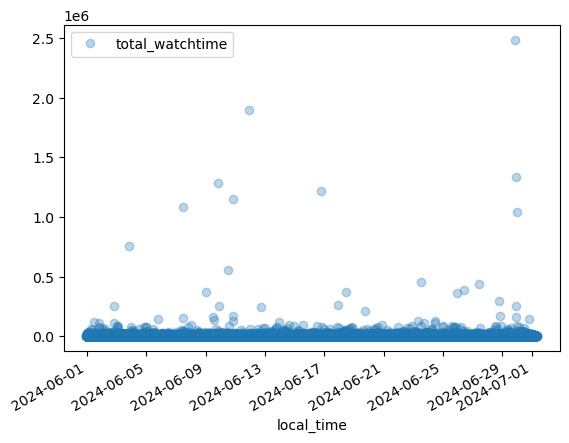

In [194]:
train_events_df[['total_watchtime', 'local_time']].set_index('local_time').plot(style='o', alpha=0.3)


In [195]:
train_events_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1759616 entries, 0 to 1759615
Data columns (total 10 columns):
 #   Column           Dtype                    
---  ------           -----                    
 0   event_timestamp  datetime64[ns, UTC+03:00]
 1   region           object                   
 2   ua_device_type   object                   
 3   ua_client_type   object                   
 4   ua_os            object                   
 5   ua_client_name   object                   
 6   total_watchtime  int64                    
 7   rutube_video_id  object                   
 8   viewer_uid       int64                    
 9   local_time       datetime64[ns]           
dtypes: datetime64[ns, UTC+03:00](1), datetime64[ns](1), int64(2), object(6)
memory usage: 134.2+ MB


Количество дубликатов по id в all_event.

In [10]:
all_events_df[['rutube_video_id' ,'viewer_uid']].duplicated().sum()

786206

In [49]:
print(len(all_events_df['viewer_uid']))
all_events_df['viewer_uid'].nunique()


8439624


960885

In [33]:
train_events_df['viewer_uid'].nunique()

180012

<Axes: >

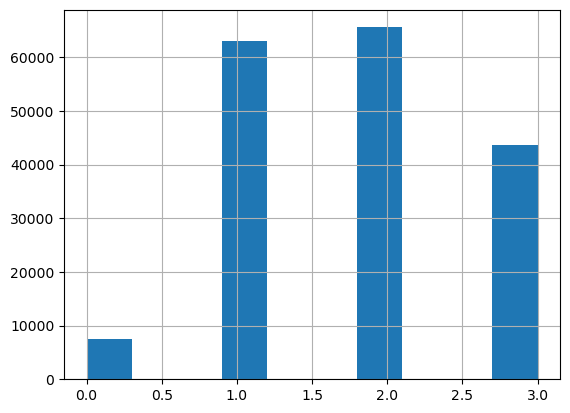

In [34]:
train_targets_df['age_class'].hist()